In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import time
import os

In [2]:
class Network(nn.Module):
    def __init__(self,num_input=2,layers=[64, 64, 64],num_output=3):
        super(Network,self).__init__()
        self.input_layer=nn.Linear(num_input,layers[0])
        self.hidden_layer=nn.ModuleList()
        for i in range(len(layers)-1):
            self.hidden_layer.append(nn.Linear(layers[i],layers[i+1]))
        self.output_layer=nn.Linear(layers[-1],num_output)
    def forward(self,out):
        out=torch.tanh(self.input_layer(out))
        for layer in self.hidden_layer:
            out=torch.tanh(layer(out))
        out=self.output_layer(out)
        return out

In [3]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)

        # Assumptions
        self.rho=1.0
        self.nu=0.01
        self.u0=1.0

        # Domain_Definition
        dx=0.005
        dy=0.005
        self.x=torch.arange(0,1+dx,dx)
        self.y=torch.arange(0,1+dy,dy)
        self.X = torch.stack(torch.meshgrid(self.x,self.y)).reshape(2,-1).T

        # Transfer tensor to GPU
        self.X = self.X.to(self.device)

        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters())
        # , lr=1e-4
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=1.0,
            max_iter = 1000,
            max_eval = 1000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
    def loss_f(self):
        # Restart Optimizer
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # Network prediction
        self.uvp_P = self.network(self.X)
        self.u_P = self.uvp_P[:, 0].reshape(len(self.x), len(self.y))
        self.v_P = self.uvp_P[:, 1].reshape(len(self.x), len(self.y))
        self.p_P = self.uvp_P[:, 2].reshape(len(self.x), len(self.y))

        # Apply hard boundary conditions
        self.u_P[0, :], self.u_P[-1, :], self.u_P[:, 0], self.u_P[:, -1] = 0.0, 0.0, 0.0, self.u0
        self.v_P[0, :], self.v_P[-1, :], self.v_P[:, 0], self.v_P[:, -1] = 0.0, 0.0, 0.0, 0.0

        dx = self.x[1] - self.x[0]
        dy = self.y[1] - self.y[0]
        
        #Second order diff
        def central_diff_x(arr):
            res = torch.zeros_like(arr)
            res[1:-1, :] = (arr[2:, :] - arr[:-2, :]) / (2 * dx)
            return res

        def central_diff_y(arr):
            res = torch.zeros_like(arr)
            res[:, 1:-1] = (arr[:, 2:] - arr[:, :-2]) / (2 * dy)
            return res

        def second_diff_x(arr):
            res = torch.zeros_like(arr)
            res[1:-1, :] = (arr[2:, :] - 2 * arr[1:-1, :] + arr[:-2, :]) / (dx ** 2)
            return res

        def second_diff_y(arr):
            res = torch.zeros_like(arr)
            res[:, 1:-1] = (arr[:, 2:] - 2 * arr[:, 1:-1] + arr[:, :-2]) / (dy ** 2)
            return res
    
        # # forth order diff
        # def central_diff_x(arr):
        #     res = torch.zeros_like(arr)
        #     res[2:-2, :] = (-arr[4:, :] + 8*arr[3:-1, :] - 8*arr[1:-3, :] + arr[0:-4, :]) / (12 * dx)
        #     return res

        # def central_diff_y(arr):
        #     res = torch.zeros_like(arr)
        #     res[:, 2:-2] = (-arr[:, 4:] + 8*arr[:, 3:-1] - 8*arr[:, 1:-3] + arr[:, 0:-4]) / (12 * dy)
        #     return res
       
        # def second_diff_x(arr):
        #     res = torch.zeros_like(arr)
        #     res[2:-2, :] = (-arr[4:, :] + 16*arr[3:-1, :] - 30*arr[2:-2, :] + 16*arr[1:-3, :] - arr[0:-4, :]) / (12 * dx**2)
        #     return res

        # def second_diff_y(arr):
        #     res = torch.zeros_like(arr)
        #     res[:, 2:-2] = (-arr[:, 4:] + 16*arr[:, 3:-1] - 30*arr[:, 2:-2] + 16*arr[:, 1:-3] - arr[:, 0:-4]) / (12 * dy**2)
        #     return res

        du_dx = central_diff_x(self.u_P)
        du_dy = central_diff_y(self.u_P)
        du_dxx = second_diff_x(self.u_P)
        du_dyy = second_diff_y(self.u_P)

        dv_dx = central_diff_x(self.v_P)
        dv_dy = central_diff_y(self.v_P)
        dv_dxx = second_diff_x(self.v_P)
        dv_dyy = second_diff_y(self.v_P)
    
        dp_dx = central_diff_x(self.p_P)
        dp_dy = central_diff_y(self.p_P)

        # Extract interior points
        slice_in = slice(1, -1)
        u_int = self.u_P[slice_in, slice_in]
        v_int = self.v_P[slice_in, slice_in]
        du_dx_int = du_dx[slice_in, slice_in]
        du_dy_int = du_dy[slice_in, slice_in]
        du_dxx_int = du_dxx[slice_in, slice_in]
        du_dyy_int = du_dyy[slice_in, slice_in]
        dv_dx_int = dv_dx[slice_in, slice_in]
        dv_dy_int = dv_dy[slice_in, slice_in]
        dv_dxx_int = dv_dxx[slice_in, slice_in]
        dv_dyy_int = dv_dyy[slice_in, slice_in]
        dp_dx_int = dp_dx[slice_in, slice_in]
        dp_dy_int = dp_dy[slice_in, slice_in]

        # Compute PDE residuals
        con_equ = du_dx_int + dv_dy_int
        u_eqn = u_int * du_dx_int + v_int * du_dy_int + dp_dx_int / self.rho - self.nu * (du_dxx_int + du_dyy_int)
        v_eqn = u_int * dv_dx_int + v_int * dv_dy_int + dp_dy_int / self.rho - self.nu * (dv_dxx_int + dv_dyy_int)

        # Calculate loss
        self.loss = self.criterion(con_equ.reshape(-1), torch.zeros_like(con_equ).reshape(-1)) + \
                    self.criterion(u_eqn.reshape(-1), torch.zeros_like(u_eqn).reshape(-1)) + \
                    self.criterion(v_eqn.reshape(-1), torch.zeros_like(v_eqn).reshape(-1))

        # print(self.criterion(con_equ.reshape(-1), torch.zeros_like(con_equ).reshape(-1)))
        # print(self.criterion(u_eqn.reshape(-1), torch.zeros_like(u_eqn).reshape(-1)))
        # print(self.criterion(v_eqn.reshape(-1), torch.zeros_like(v_eqn).reshape(-1)))

        self.loss.backward()
        return self.loss
    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.6f}")
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)
    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            self.u = self.uvp_P[:,0].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.v = self.uvp_P[:,1].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.p = self.uvp_P[:,2].reshape(len(self.x), len(self.y)).cpu().numpy().T
        plt.figure(figsize=(10, 8))
        plt.subplot(2, 2, 1)
        contour1 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, levels=50, cmap="jet")
        plt.colorbar(contour1)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("u")
        plt.subplot(2, 2, 2)
        contour2 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.v, levels=50, cmap="jet")
        plt.colorbar(contour2)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("v")
        plt.subplot(2, 2, 3)
        contour3 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.p, levels=50, cmap="jet")
        plt.colorbar(contour3)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("pressure")
        plt.figure(figsize=(8, 8))
        # plt.subplot(2, 2, 4)
        # contour4 = plt.streamplot(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, self.v, color=self.u, linewidth=2, cmap='autumn')
        # plt.xlabel("X")
        # plt.ylabel("Y")
        # plt.title("streamline")
        # plt.tight_layout()
        # plt.show()

/home/hossein_vasheghani/.conda/envs/hossein_vasheghani/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 0, Loss: 811.949585
Iteration 10, Loss: 325.215363
Iteration 20, Loss: 315.413574
Iteration 30, Loss: 304.768585
Iteration 40, Loss: 299.657959
Iteration 50, Loss: 293.532196
Iteration 60, Loss: 288.704376
Iteration 70, Loss: 282.917450
Iteration 80, Loss: 276.058197
Iteration 90, Loss: 267.340759
Iteration 100, Loss: 255.771652
Iteration 110, Loss: 239.890396
Iteration 120, Loss: 217.807022
Iteration 130, Loss: 188.128067
Iteration 140, Loss: 153.342072
Iteration 150, Loss: 124.545425
Iteration 160, Loss: 113.264526
Iteration 170, Loss: 107.985237
Iteration 180, Loss: 102.344566
Iteration 190, Loss: 95.997780
Iteration 200, Loss: 89.716354
Iteration 210, Loss: 84.084763
Iteration 220, Loss: 79.876419
Iteration 230, Loss: 77.291016
Iteration 240, Loss: 75.787735
Iteration 250, Loss: 74.667572
Iteration 260, Loss: 73.761635
Iteration 270, Loss: 74.911362
Iteration 280, Loss: 71.607986
Iteration 290, Loss: 70.464890
Iteration 300, Loss: 68.841423
Iteration 310, Loss: 67.493256


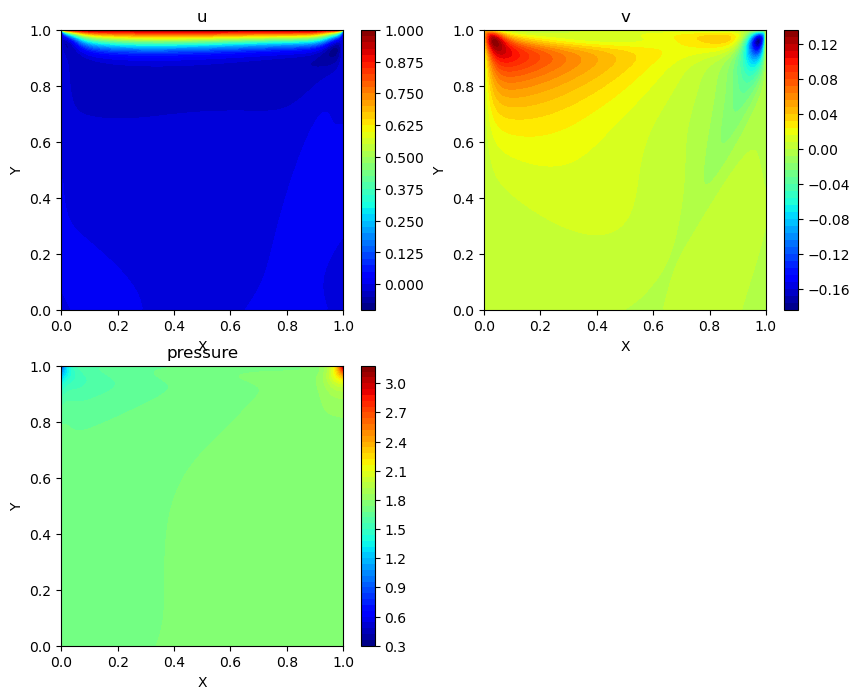

<Figure size 800x800 with 0 Axes>

In [4]:
net = Pinns()
# net.network.load_state_dict(torch.load(r'/home/hossein_vasheghani/modelFF_6.pth'))
net.train(num_epochs=10000)
net.plot()

In [14]:
torch.save(net.network.state_dict(), r'/home/hossein_vasheghani/modelFF_6.pth')

In [5]:
# Given validation data for R=1000
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.18109, -0.20196, -0.22220, -0.29730, -0.38289, -0.27805, -0.10648,
                          -0.06080, 0.05702, 0.18719, 0.33304, 0.46604, 0.51117, 0.57492, 0.65928, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.27485, 0.29012, 0.30353, 0.32627, 0.37095, 0.33075, 0.32235, 0.02526,
                          -0.31966, -0.42665, -0.51550, -0.39188, -0.33714, -0.27669, -0.21388, 0])

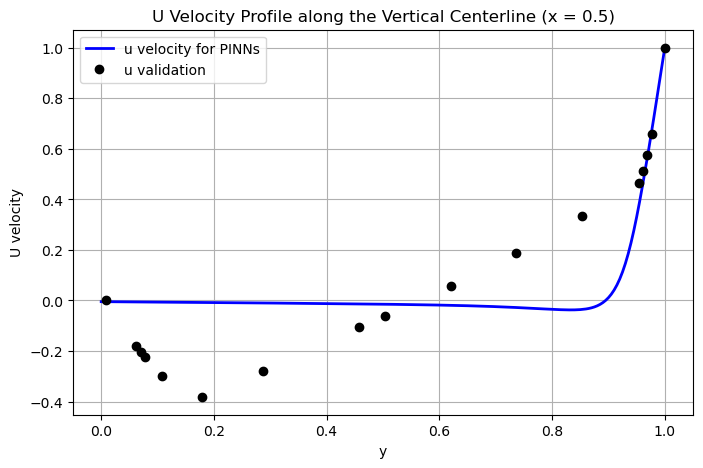

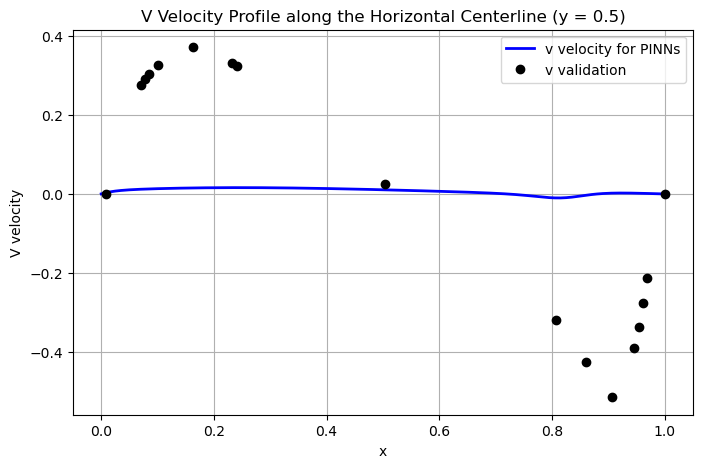

In [6]:
with torch.no_grad():
    uvp_pred = net.network(net.X).reshape(len(net.x), len(net.y), 3)

u = uvp_pred[:, :, 0].detach().cpu().numpy()
v = uvp_pred[:, :, 1].detach().cpu().numpy()

# Plot u velocity along vertical centerline (x = 0.5)
plt.figure(figsize=(8, 5))
center_idx_x = len(net.x) // 2
plt.plot(net.y.cpu(), u[center_idx_x, :], 'b-', linewidth=2, label='u velocity for PINNs')
plt.plot(x_validation, u_validation2, 'ko', label="u validation", markersize=6, linewidth=2)
plt.xlabel("y")
plt.ylabel("U velocity")
plt.title("U Velocity Profile along the Vertical Centerline (x = 0.5)")
plt.legend()
plt.grid(True)
plt.show()

# Plot v velocity along horizontal centerline (y = 0.5)
plt.figure(figsize=(8, 5))
center_idx_y = len(net.y) // 2
plt.plot(net.x.cpu(), v[:, center_idx_y], 'b-', linewidth=2, label='v velocity for PINNs')
plt.plot(y_validation, v_validation2, 'ko', label="v validation", markersize=6, linewidth=2)
plt.xlabel("x")
plt.ylabel("V velocity")
plt.title("V Velocity Profile along the Horizontal Centerline (y = 0.5)")
plt.legend()
plt.grid(True)
plt.show()